In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
import torchvision
torchvision.__version__  # should be 0.2.1

'0.14.1+cu117'

In [21]:
input_path = "valve/train_v1/"
train_dir = 'valve/train_v1/train'   # Update paths
val_dir = 'valve/train_v1/val'
import os 
os.listdir()

['.ipynb_checkpoints',
 'data',
 'cats_and_dogs-1.ipynb',
 'best_model.pth',
 'vit_model.onnx',
 'model-repository',
 'cropped-frames-2.zip',
 'cropped-frames-2',
 'suhana_Horizontal_Vertical.ipynb',
 'blue channel.png',
 'green channel.png',
 'red channel.png',
 'frame1_image-1.png',
 'hsv-frame1.png',
 'data-hor-ver',
 'horizontal',
 'test.py',
 'image-classification-by-resnet-50.ipynb',
 'onnx.ipynb',
 'onnx(1).ipynb',
 'onnx_resnet.ipynb',
 'valve',
 'scoop_v1.pt',
 'valve.pt',
 'Untitled.ipynb',
 'best_vit_model.pt']

In [22]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        
    ]),
}


In [23]:
image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'val', data_transforms['validation'])
}

In [24]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=128,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(nn.Linear(2048, 128),nn.ReLU(inplace=True),nn.Linear(128, 2)).to(device)# add number of classes


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [28]:
def train_model(model, criterion, optimizer, num_epochs=3):
    optimizer.zero_grad()
    for epoch in range(num_epochs):                                                                            
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                with torch.cuda.amp.autocast():
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.double() / len(image_datasets[phase])
    
    
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [29]:
model_trained = train_model(model, criterion, optimizer, num_epochs=8)

Epoch 1/8
----------
train loss: 0.6248, acc: 0.6074
validation loss: 0.5992, acc: 0.5000
Epoch 2/8
----------
train loss: 0.4691, acc: 0.7516
validation loss: 0.4492, acc: 0.8943
Epoch 3/8
----------
train loss: 0.2473, acc: 0.9252
validation loss: 0.3467, acc: 0.8984
Epoch 4/8
----------
train loss: 0.1674, acc: 0.9653
validation loss: 0.4179, acc: 0.7724
Epoch 5/8
----------
train loss: 0.1310, acc: 0.9772
validation loss: 0.1743, acc: 0.8984
Epoch 6/8
----------
train loss: 0.0822, acc: 0.9848
validation loss: 0.1074, acc: 0.9512
Epoch 7/8
----------
train loss: 0.0643, acc: 0.9924
validation loss: 0.1004, acc: 0.9390
Epoch 8/8
----------
train loss: 0.0514, acc: 0.9935
validation loss: 0.0912, acc: 0.9472


train loss: 0.0179, acc: 0.9933
validation loss: 0.0157, acc: 1.0000
Epoch 90/100
----------
train loss: 0.0186, acc: 0.9933
validation loss: 0.0202, acc: 0.9949
Epoch 91/100
----------
train loss: 0.0249, acc: 0.9906
validation loss: 0.0147, acc: 1.0000
Epoch 92/100
----------
train loss: 0.0314, acc: 0.9893
validation loss: 0.0092, acc: 1.0000
Epoch 93/100
----------
train loss: 0.0285, acc: 0.9893
validation loss: 0.0152, acc: 1.0000
Epoch 94/100
----------
train loss: 0.0340, acc: 0.9879
validation loss: 0.0531, acc: 0.9646
Epoch 95/100
----------
train loss: 0.0306, acc: 0.9933
validation loss: 0.0040, acc: 1.0000
Epoch 96/100
----------
train loss: 0.0270, acc: 0.9919
validation loss: 0.0551, acc: 0.9646
Epoch 97/100
----------
train loss: 0.0213, acc: 0.9919
validation loss: 0.0036, acc: 1.0000
Epoch 98/100
----------
train loss: 0.0232, acc: 0.9919
validation loss: 0.0218, acc: 0.9949
Epoch 99/100
----------
train loss: 0.0184, acc: 0.9946
validation loss: 0.0084, acc: 1.0000
E

In [30]:
torch.save(model_trained.state_dict(), 'valve.pt')

In [31]:
model = models.resnet50(pretrained=False).to(device)

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2), nn.Softmax(1) ).to(device)# add number of classes 
model.load_state_dict(torch.load('valve.pt'))

<All keys matched successfully>

In [32]:

validation_img_paths = ["data-hor-ver/val/horizontal.horizontal_folder2_frame2_image-6.png","data-hor-ver/val/vertical.vertical_folder6_frame1_image-196.png"]

In [34]:
img_list = [Image.open( img_path) for img_path in validation_img_paths]
img_list
model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load image
# img_path = "/mnt/data/folder10_frame1_image-2157.png"
# image = Image.open(img_path).convert("RGB")
input_tensor = transform(img_list[0]).unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    confidence = torch.max(output).item()

# Define class labels (change as per your dataset)
class_labels = ['OFF', 'ON']  # adjust as needed

# Print result
print(f"Prediction: {class_labels[predicted_class]} ({confidence:.2f} confidence)")

Prediction: OFF (1.00 confidence)


In [17]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])


In [18]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor


tensor([[0.9458, 0.0542],
        [0.0332, 0.9668]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [19]:


pred_probs = pred_logits_tensor.cpu().data.numpy()


dataloaders.items()

dict_items([('train', <torch.utils.data.dataloader.DataLoader object at 0x7fe7f198d160>), ('validation', <torch.utils.data.dataloader.DataLoader object at 0x7fe7f198d640>)])

IndexError: index 2 is out of bounds for axis 1 with size 2

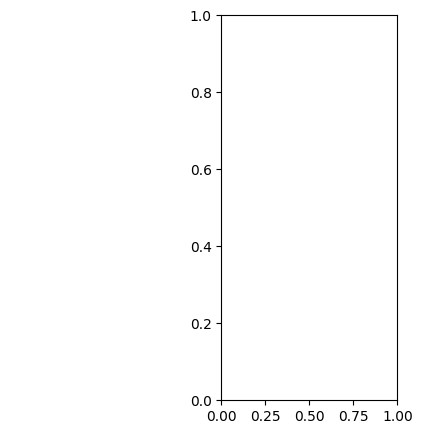

In [20]:
fig, axs = plt.subplots(1, len(img_list), figsize=(5, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% {:.0f}% {:.0f}% {:.0f}%".format(100*pred_probs[i,0],100*pred_probs[i,1],100*pred_probs[i,2],100*pred_probs[i,3]))
    ax.imshow(img)

In [ ]:
image_datasets['train'].classes

In [ ]:
input_names = [ "input" ]
output_names = [ "output" ]

In [ ]:
dummy_input = torch.autograd.Variable(torch.randn(1, 3, 224, 224))

In [ ]:
torch.onnx.export(model, dummy_input.cuda(), 'scoop.onnx', input_names=input_names, output_names=output_names)